In [1]:
######## snakemake preamble start (automatically inserted, do not edit) ########
import sys

sys.path.extend(
    [
        "/iblm/netapp/data3/mcuoco/sz_slavseq/.conda/lib/python3.12/site-packages",
        "/iblm/netapp/data3/mcuoco/sz_slavseq/workflow/rules",
        "/iblm/netapp/data3/mcuoco/sz_slavseq/workflow",
        "/iblm/netapp/data3/mcuoco/sz_slavseq/.conda/bin",
        "/iblm/netapp/data3/mcuoco/sz_slavseq/.conda/lib/python3.12",
        "/iblm/netapp/data3/mcuoco/sz_slavseq/.conda/lib/python3.12/lib-dynload",
        "/iblm/netapp/data3/mcuoco/sz_slavseq/.conda/lib/python3.12/site-packages",
        "/root/.cache/snakemake/snakemake/source-cache/runtime-cache/tmpaj7or0jh/file/iblm/netapp/data3/mcuoco/sz_slavseq/workflow/rules/../scripts",
        "/iblm/netapp/data3/mcuoco/sz_slavseq/workflow/rules/../scripts",
    ]
)
import pickle

snakemake = pickle.loads(
    b'\x80\x04\x95\x91\x19\x00\x00\x00\x00\x00\x00\x8c\x10snakemake.script\x94\x8c\tSnakemake\x94\x93\x94)\x81\x94}\x94(\x8c\x05input\x94\x8c\x0csnakemake.io\x94\x8c\nInputFiles\x94\x93\x94)\x81\x94(\x8cf/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/predictions.pqt\x94\x8cQ/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/bulk.pqt\x94e}\x94(\x8c\x06_names\x94}\x94(\x8c\x04data\x94K\x00N\x86\x94\x8c\x04bulk\x94K\x01K\x02\x86\x94u\x8c\x12_allowed_overrides\x94]\x94(\x8c\x05index\x94\x8c\x04sort\x94eh\x15\x8c\tfunctools\x94\x8c\x07partial\x94\x93\x94h\x06\x8c\x19Namedlist._used_attribute\x94\x93\x94\x85\x94R\x94(h\x1b)}\x94\x8c\x05_name\x94h\x15sNt\x94bh\x16h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x16sNt\x94bh\x0fh\nh\x11h\x06\x8c\tNamedlist\x94\x93\x94)\x81\x94h\x0ba}\x94(h\r}\x94h\x13]\x94(h\x15h\x16eh\x15h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x15sNt\x94bh\x16h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x16sNt\x94bubub\x8c\x06output\x94h\x06\x8c\x0bOutputFiles\x94\x93\x94)\x81\x94(\x8cb/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/1.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/10.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/11.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/12.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/13.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/17.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/20.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/22.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/24.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/25.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/26.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/27.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/30.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/36.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/37.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/38.calls.bed\x94\x8cb/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/3.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/41.calls.bed\x94\x8cb/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/4.calls.bed\x94\x8cb/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/7.calls.bed\x94\x8cb/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/8.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/15.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/21.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/33.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/14.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/16.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/19.calls.bed\x94\x8cb/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/2.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/28.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/31.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/32.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/35.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/39.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/42.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/43.calls.bed\x94\x8cc/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/46.calls.bed\x94\x8cb/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/5.calls.bed\x94e}\x94(h\r}\x94h\x13]\x94(h\x15h\x16eh\x15h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x15sNt\x94bh\x16h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x16sNt\x94bub\x8c\x06params\x94h\x06\x8c\x06Params\x94\x93\x94)\x81\x94}\x94(h\r}\x94h\x13]\x94(h\x15h\x16eh\x15h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x15sNt\x94bh\x16h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x16sNt\x94bub\x8c\twildcards\x94h\x06\x8c\tWildcards\x94\x93\x94)\x81\x94(\x8c$/iblm/netapp/data3/mcuoco/sz_slavseq\x94\x8c\x0cchm13v2.0.XY\x94\x8c\x08filtered\x94\x8c\rset3_germdist\x94e}\x94(h\r}\x94(\x8c\x06outdir\x94K\x00N\x86\x94\x8c\x06genome\x94K\x01N\x86\x94\x8c\x05reads\x94K\x02N\x86\x94\x8c\x08features\x94K\x03N\x86\x94uh\x13]\x94(h\x15h\x16eh\x15h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x15sNt\x94bh\x16h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x16sNt\x94b\x8c\x06outdir\x94hz\x8c\x06genome\x94h{\x8c\x05reads\x94h|\x8c\x08features\x94h}ub\x8c\x07threads\x94K\x01\x8c\tresources\x94h\x06\x8c\tResources\x94\x93\x94)\x81\x94(K\x01K\x01\x8c\x04/tmp\x94e}\x94(h\r}\x94(\x8c\x06_cores\x94K\x00N\x86\x94\x8c\x06_nodes\x94K\x01N\x86\x94\x8c\x06tmpdir\x94K\x02N\x86\x94uh\x13]\x94(h\x15h\x16eh\x15h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x15sNt\x94bh\x16h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x16sNt\x94bh\x9dK\x01h\x9fK\x01h\xa1h\x9aub\x8c\x03log\x94h\x06\x8c\x03Log\x94\x93\x94)\x81\x94\x8ci/iblm/netapp/data3/mcuoco/sz_slavseq/results/chm13v2.0.XY/filtered/peaks/set3_germdist/calls_report.ipynb\x94a}\x94(h\r}\x94\x8c\x08notebook\x94K\x00N\x86\x94sh\x13]\x94(h\x15h\x16eh\x15h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x15sNt\x94bh\x16h\x19h\x1b\x85\x94R\x94(h\x1b)}\x94h\x1fh\x16sNt\x94bh\xb3h\xb0ub\x8c\x06config\x94}\x94(\x8c\x07samples\x94\x8c\x16config/all_samples.tsv\x94\x8c\x06donors\x94\x8c\x15config/all_donors.tsv\x94\x8c\x06outdir\x94\x8c$/iblm/netapp/data3/mcuoco/sz_slavseq\x94\x8c\x06genome\x94}\x94(\x8c\x05fasta\x94\x8c)resources/chm13v2.0.XY/chm13v2.0.XY.fasta\x94\x8c\x03fai\x94\x8c-resources/chm13v2.0.XY/chm13v2.0.XY.fasta.fai\x94\x8c\x06genome\x94\x8c/resources/chm13v2.0.XY/chm13v2.0.XY.chrom.sizes\x94\x8c\x03bwa\x94\x8c-resources/chm13v2.0.XY/BWA/chm13v2.0.XY.fasta\x94\x8c\x0fmegane_gaussian\x94\x8c:resources/chm13v2.0.XY/wgs_calls/megane_joint_gaussian.vcf\x94\x8c\x11megane_percentile\x94\x8c<resources/chm13v2.0.XY/wgs_calls/megane_joint_percentile.vcf\x94\x8c\x08graffite\x94\x8cAresources/chm13v2.0.XY/wgs_calls/GraffiTE.merged.genotypes.vcf.gz\x94\x8c\x04xtea\x94\x8c/resources/chm13v2.0.XY/wgs_calls/xtea_LINE1.vcf\x94\x8c\x04name\x94\x8c\x0cchm13v2.0.XY\x94\x8c\x04size\x94\x8a\x05&\x1a\xce\xb9\x00u\x8c\x08adapters\x94}\x94(\x8c\x05p7_i7\x94\x8c%AATGATACGGCGACCACCGAGATCTACACNNNNNNNN\x94\x8c\x02r1\x94\x8c!ACACTCTTTCCCTACACGACGCTCTTCCGATCT\x94\x8c\x05p5_i5\x94\x8c\x1fCAAGCAGAAGACGGCATACGAGANNNNNNNN\x94\x8c\x02r2\x94\x8c"GTGACTGGAGTTCAGACGTGTGCTCTTCCGATCT\x94\x8c\tL1_nested\x94\x8c\x17TAACTAACCTGCACAATGTGCAC\x94\x8c\rL1_downstream\x94\x8c\x1aATGTACCCTAAAACTTAGAGTATAAT\x94u\x8c\x08features\x94]\x94(\x8c\x11frac_proper_pairs\x94\x8c\x0ffrac_duplicates\x94\x8c\x19frac_mean_supp_alignments\x94\x8c\x0cfrac_contigs\x94\x8c\x1balignment_score_normed_mean\x94\x8c\x1eL1_alignment_score_normed_mean\x94\x8c mate_alignment_score_normed_mean\x94\x8c\x10orientation_bias\x94\x8c\x10frac_unique_5end\x94\x8c\x10frac_unique_3end\x94eu\x8c\x04rule\x94\x8c\x0ccalls_report\x94\x8c\x0fbench_iteration\x94N\x8c\tscriptdir\x94\x8c>/iblm/netapp/data3/mcuoco/sz_slavseq/workflow/rules/../scripts\x94ub.'
)
from snakemake.logging import logger

logger.printshellcmds = False
import os

os.chdir(r"/iblm/netapp/data3/mcuoco/sz_slavseq");
######## snakemake preamble end #########

# SLAVseq model report

In [2]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from scipy.stats import ttest_ind
from pyslavseq.plotting import datashader_plot

## Read Data

In [3]:
data = pd.read_parquet(snakemake.input.data)  # type: ignore
meta = pd.read_csv(snakemake.config["donors"], sep="\t")  # type: ignore
meta["donor_id"] = meta["donor_id"].astype(str)
data = data.merge(meta, on="donor_id")
data["Cluster"] = data["Cluster"].astype("category")

## Distance to germline

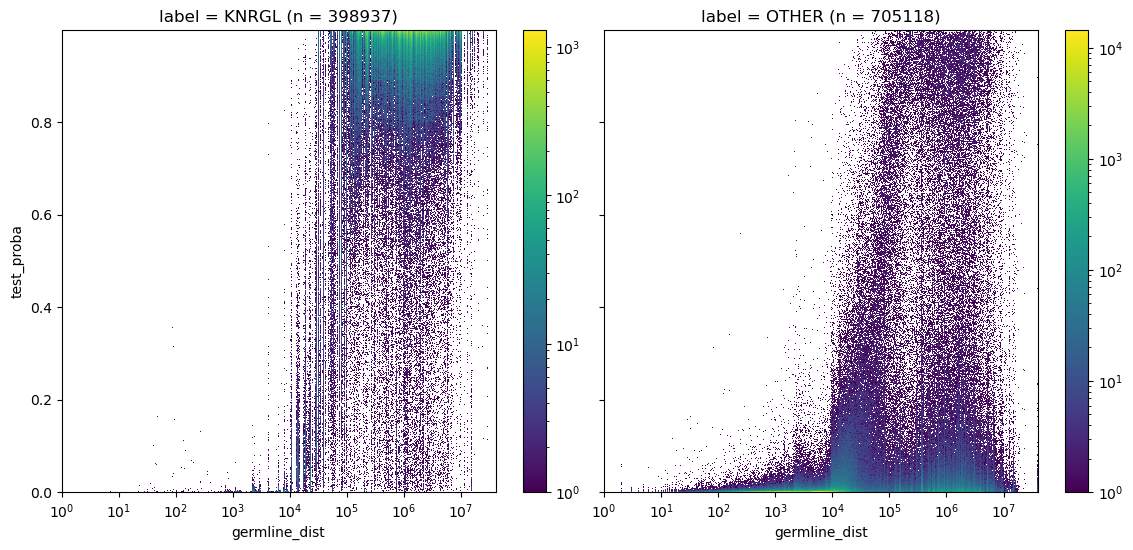

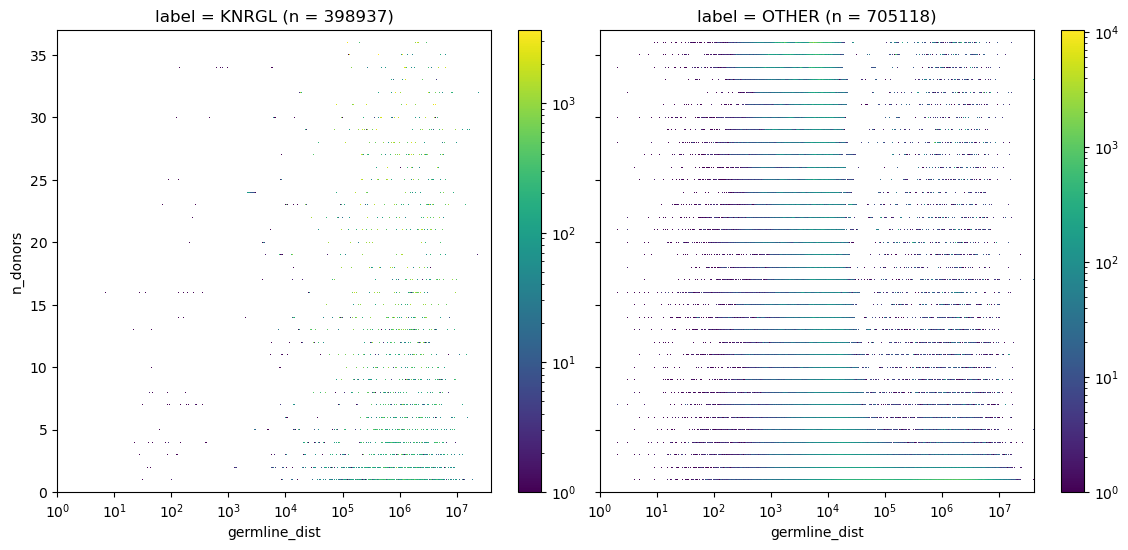

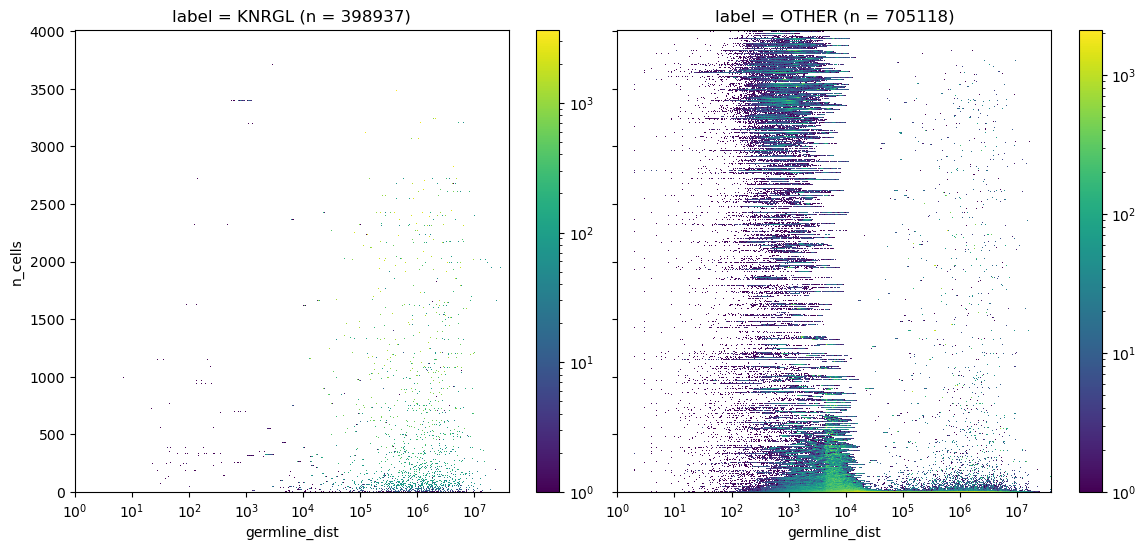

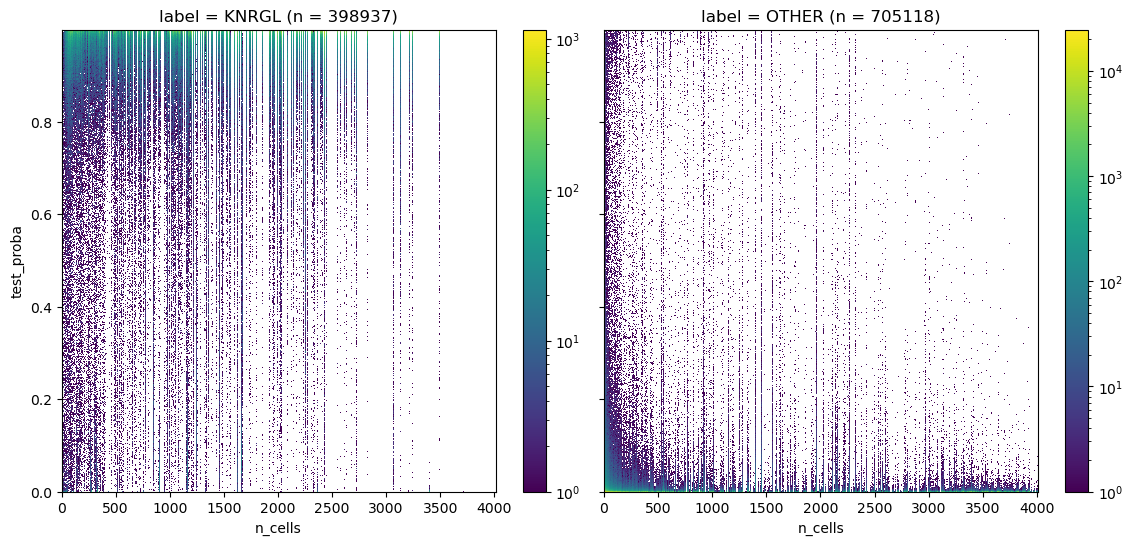

In [4]:
plots = [
    ("germline_dist", "test_proba", (True, False)),
    ("germline_dist", "n_donors", (True, False)),
    ("germline_dist", "n_cells", (True, False)),
    ("n_cells", "test_proba", (False, False)),
]

for i, (x, y, s) in enumerate(plots):
    datashader_plot(data, x, y, s)

## Inspect Potential Clonal insertions

In [5]:
# find putative clonal insertions
calls = []
for p in [0.5, 0.6, 0.7, 0.8, 0.9]:

    df = (
        data.query("not KNRGL and test_proba > @p")
        .drop(columns=["n_cells", "n_donors"])
        .reset_index(drop=True)
    )

    cells_per_call = df.groupby("Cluster", observed=True).size()
    cells_per_call.name = "n_cells"
    regions_per_call = df.groupby("Cluster", observed=True)["tissue_id"].nunique()
    regions_per_call.name = "n_regions"
    donors_per_call = df.groupby("Cluster", observed=True)["donor_id"].nunique()
    donors_per_call.name = "n_donors"
    df = df.join(cells_per_call, on="Cluster")
    df = df.join(donors_per_call, on="Cluster")
    df = df.join(regions_per_call, on="Cluster")
    df["threshold"] = p

    calls.append(df)

calls = pd.concat(calls)

g = sns.displot(
    calls, x="n_cells", y="n_donors", col="n_regions", row="threshold", kind="hist"
)

# set x to log
g.set(xscale="log")

## Putative calls


In [6]:
calls = []
for p in [0.5, 0.6, 0.7, 0.8, 0.9]:

    precision_per_cell = data.groupby(["donor_id", "cell_id"]).apply(
        lambda x: precision_score(
            x["KNRGL"], x["test_proba"] > p, zero_division=np.nan
        ),
    )
    recall_per_cell = data.groupby(["donor_id", "cell_id"]).apply(
        lambda x: recall_score(x["KNRGL"], x["test_proba"] > p, zero_division=np.nan),
    )
    calls_per_cell = (
        data.query("not KNRGL")
        .groupby(["donor_id", "cell_id"])
        .apply(lambda x: (x["test_proba"] > p).sum())
    )
    reads_per_cell = data.groupby(["donor_id", "cell_id"])["n_reads"].sum()

    # join
    df = pd.concat(
        [precision_per_cell, recall_per_cell, calls_per_cell, reads_per_cell], axis=1
    )
    df.columns = ["precision", "recall", "n_calls", "n_reads"]
    df.reset_index(inplace=True)
    df["threshold"] = p
    calls.append(df)

calls = pd.concat(calls).reset_index(drop=True)
calls["expected"] = (calls["n_calls"] * calls["precision"]) / calls["recall"]

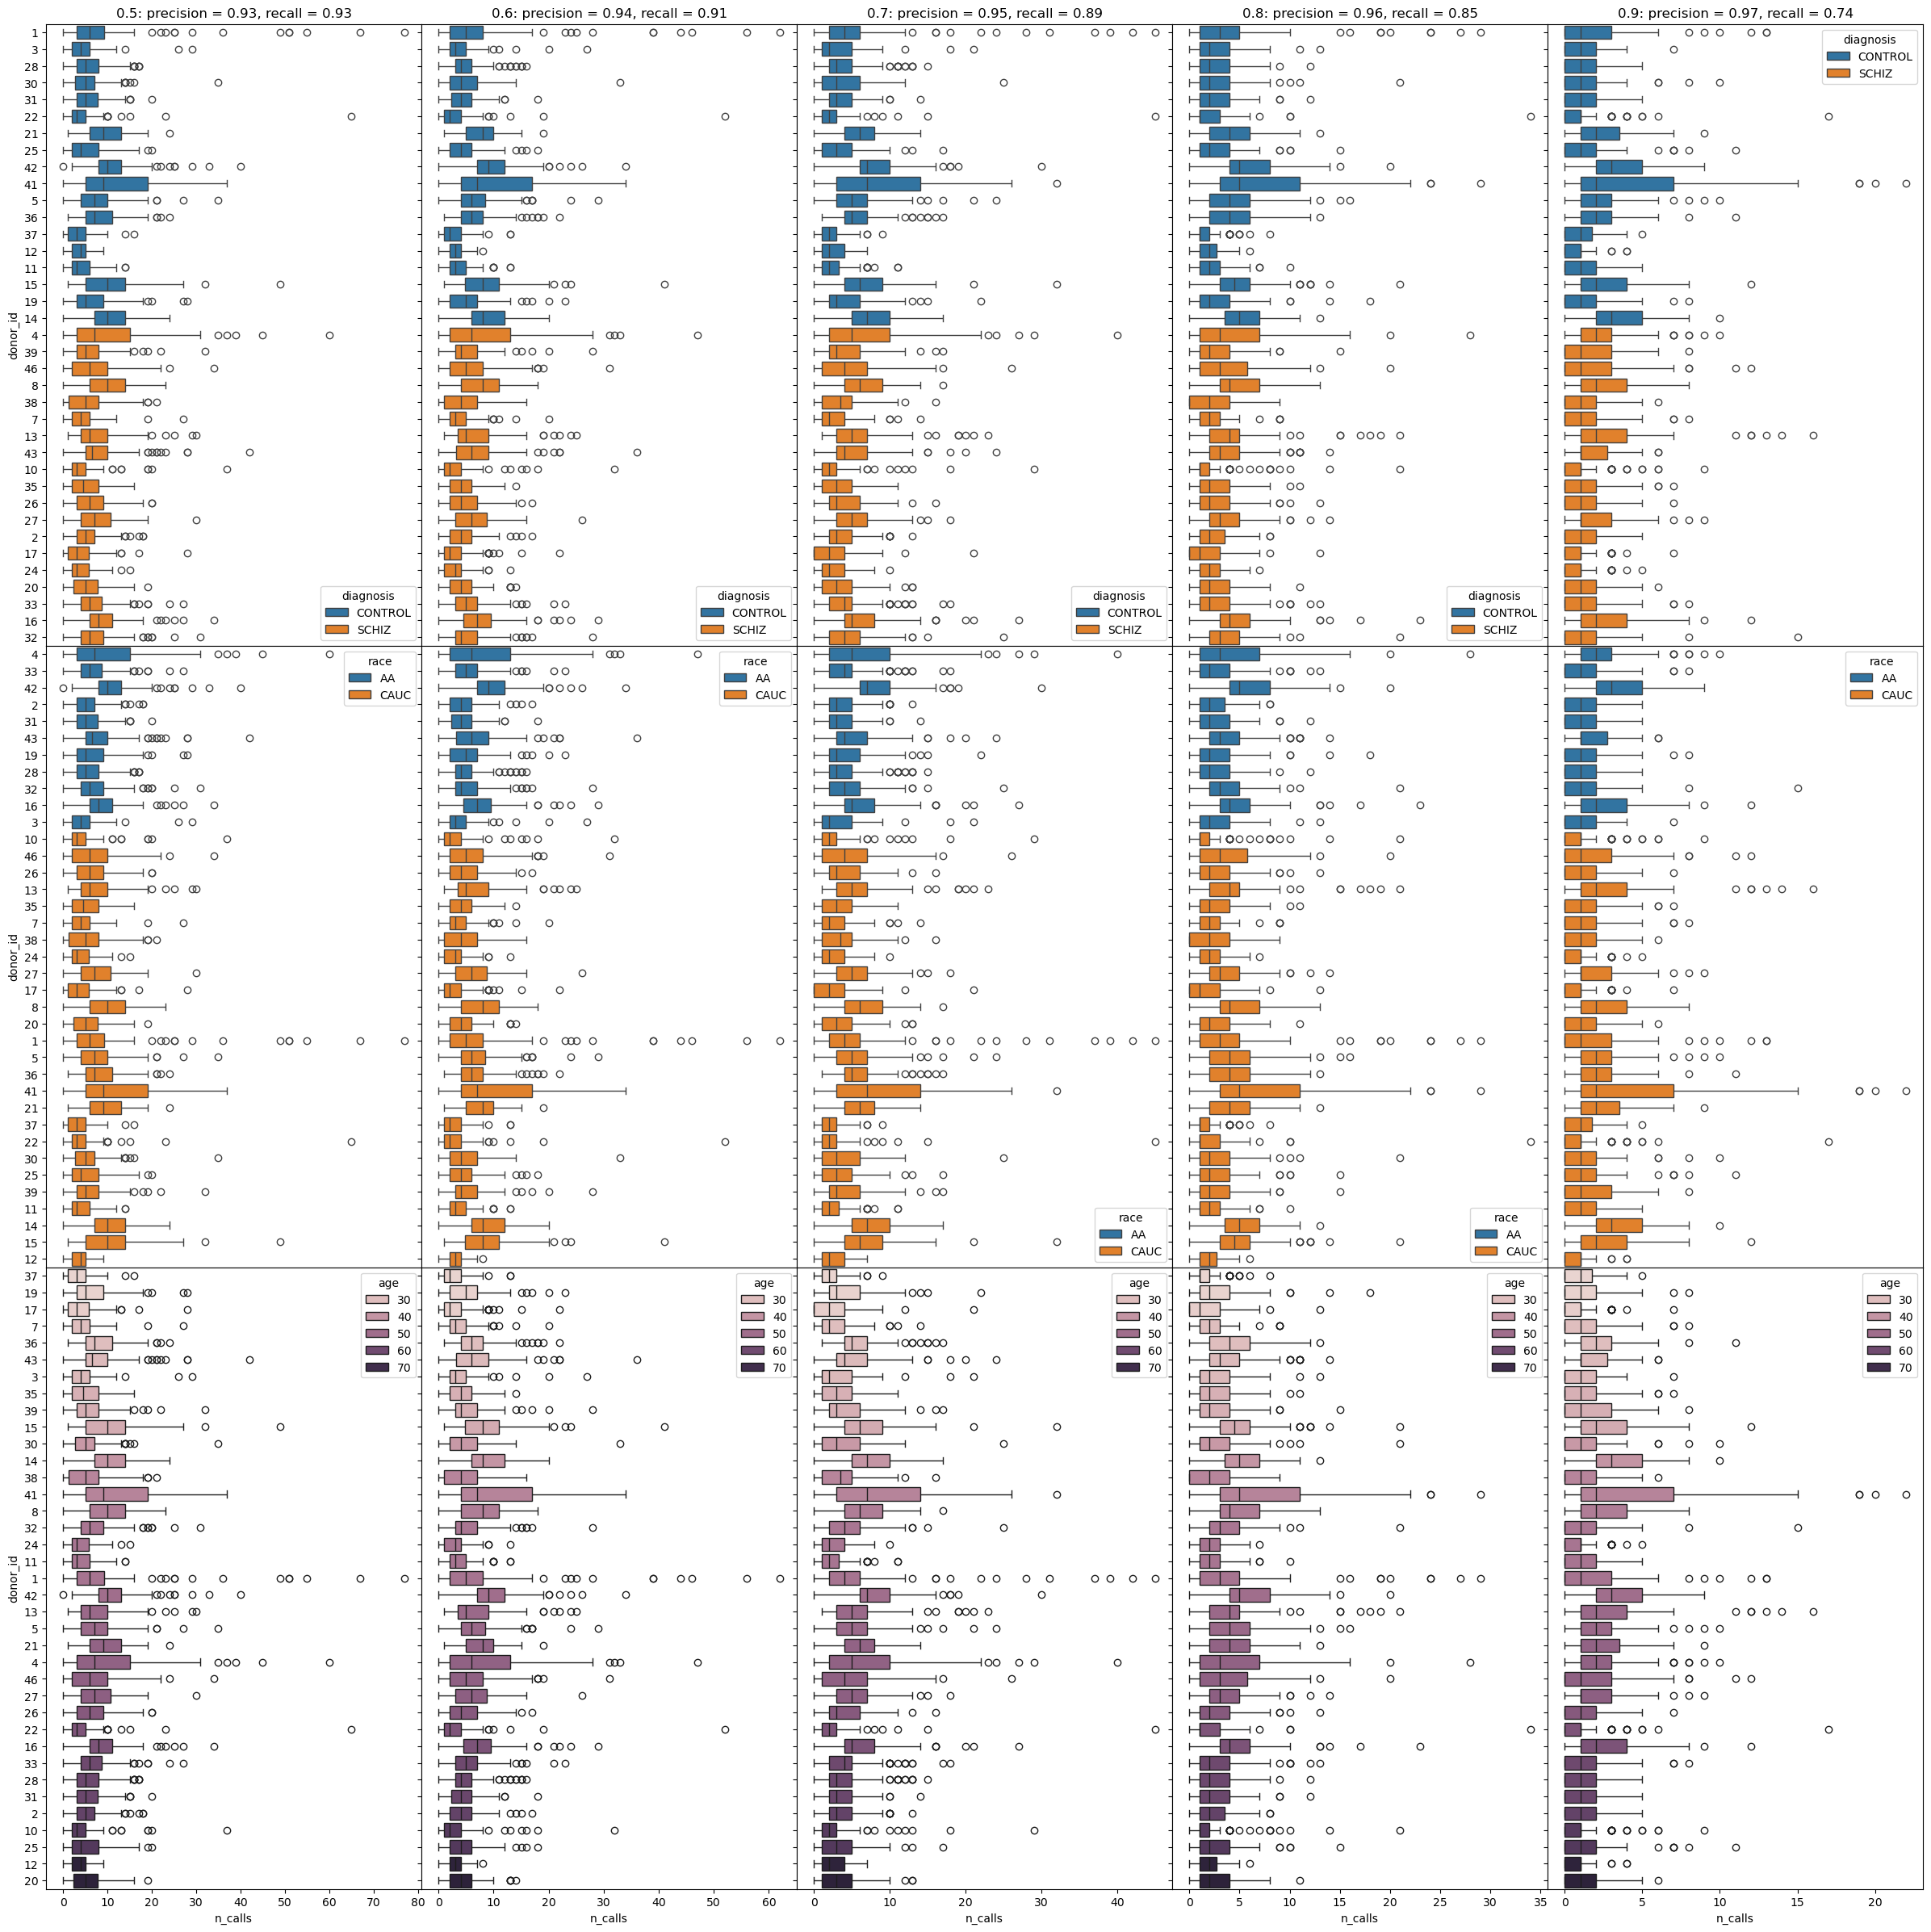

In [7]:
# insertions per cell
fig, axes = plt.subplots(3, 5, figsize=(30, 30), sharex="col", sharey="row")
fig.subplots_adjust(wspace=0, hspace=0)
for i, p in enumerate([0.5, 0.6, 0.7, 0.8, 0.9]):
    precision = precision_score(data["KNRGL"], data["test_proba"] > p)
    recall = recall_score(data["KNRGL"], data["test_proba"] > p)

    calls_per_cell = calls.query("threshold == @p")[["n_calls", "donor_id", "cell_id"]]
    calls_per_cell = calls_per_cell.merge(meta, on="donor_id")

    for j, cat in enumerate(["diagnosis", "race", "age"]):
        calls_per_cell = calls_per_cell.sort_values(cat)
        sns.boxplot(
            data=calls_per_cell, y="donor_id", x="n_calls", hue=cat, ax=axes[j, i]
        )
        axes[0, i].set_title(f"{p}: precision = {precision:.2f}, recall = {recall:.2f}")

$$
E(\text{somatic insertions}) = \frac{\text{ncalls} * (1 - \text{FDR})}{1-\text{FNR}} \\
$$

$$
E(\text{somatic insertions}) = \frac{\text{ncalls} * \text{precision}}{\text{recall}}
$$

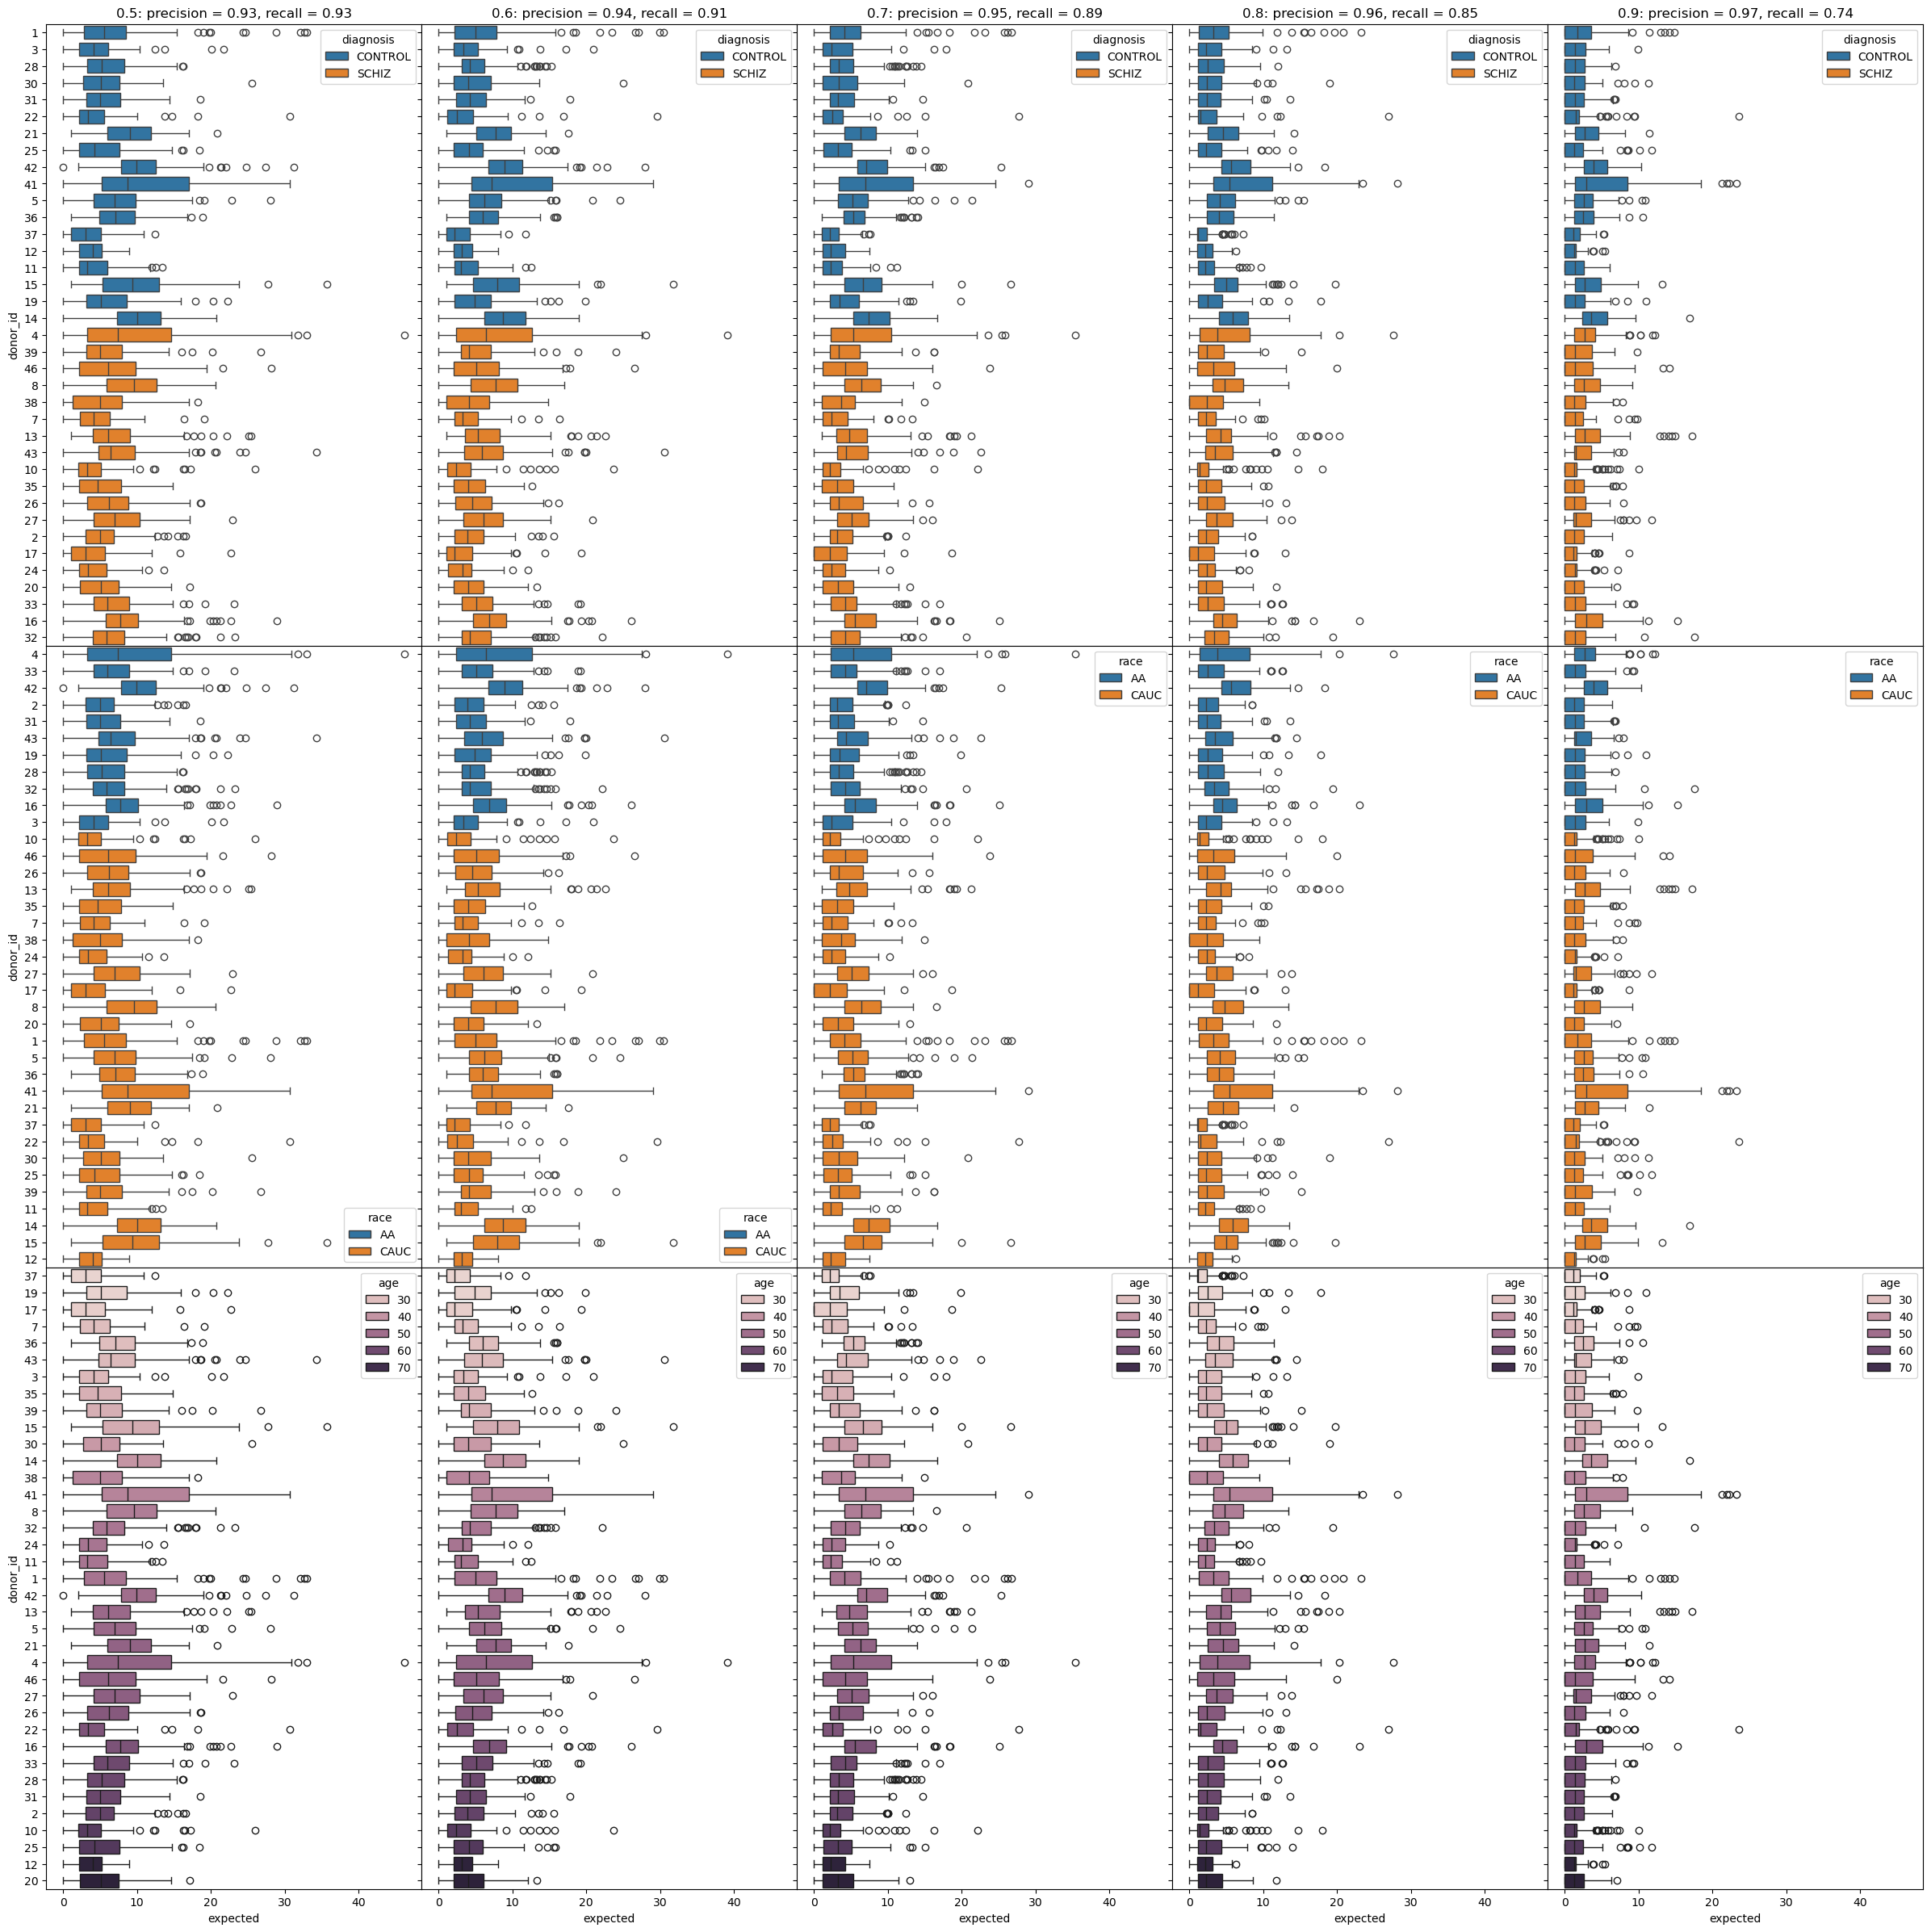

In [8]:
# compute expected insertions per cell
fig, axes = plt.subplots(3, 5, figsize=(30, 30), sharex=True, sharey="row")
fig.subplots_adjust(wspace=0, hspace=0)
for i, p in enumerate([0.5, 0.6, 0.7, 0.8, 0.9]):
    precision = precision_score(data["KNRGL"], data["test_proba"] > p)
    recall = recall_score(data["KNRGL"], data["test_proba"] > p)

    expected_per_cell = calls.query("threshold == @p")[
        ["expected", "donor_id", "cell_id"]
    ]
    expected_per_cell = expected_per_cell.merge(meta, on="donor_id")

    for j, cat in enumerate(["diagnosis", "race", "age"]):
        expected_per_cell = expected_per_cell.sort_values(cat)
        sns.boxplot(
            data=expected_per_cell, y="donor_id", x="expected", hue=cat, ax=axes[j, i]
        )
        axes[0, i].set_title(f"{p}: precision = {precision:.2f}, recall = {recall:.2f}")

In [9]:
donor_calls = (
    calls.groupby(["donor_id", "threshold"])[["n_calls", "expected"]]
    .mean()
    .reset_index()
    .merge(meta, on="donor_id")
)

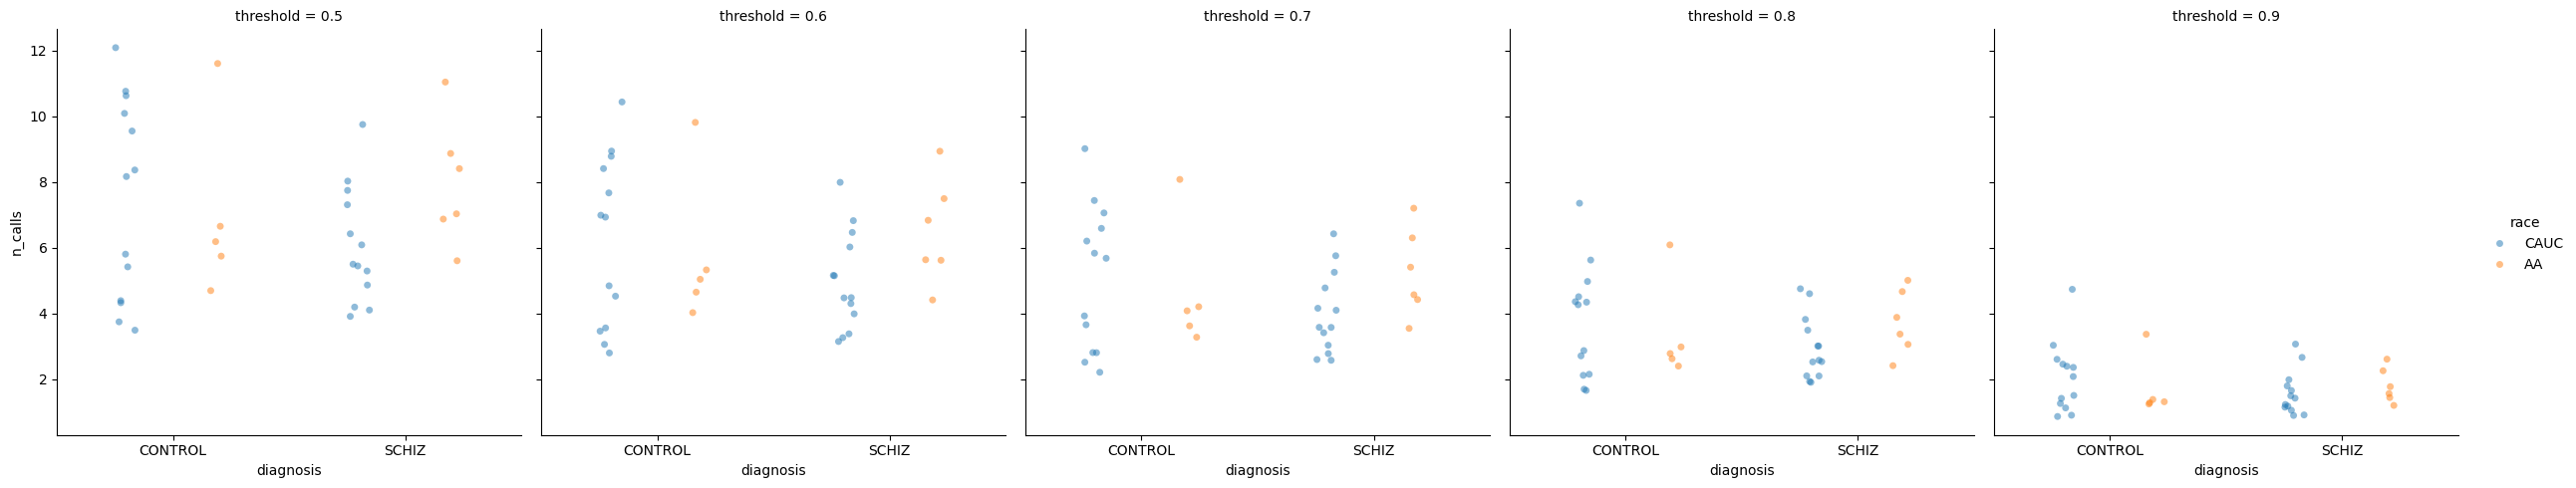

In [10]:
sns.catplot(
    data=donor_calls,
    x="diagnosis",
    y="n_calls",
    hue="race",
    col="threshold",
    kind="strip",
    alpha=0.5,
    jitter=0.1,
    dodge=True,
)

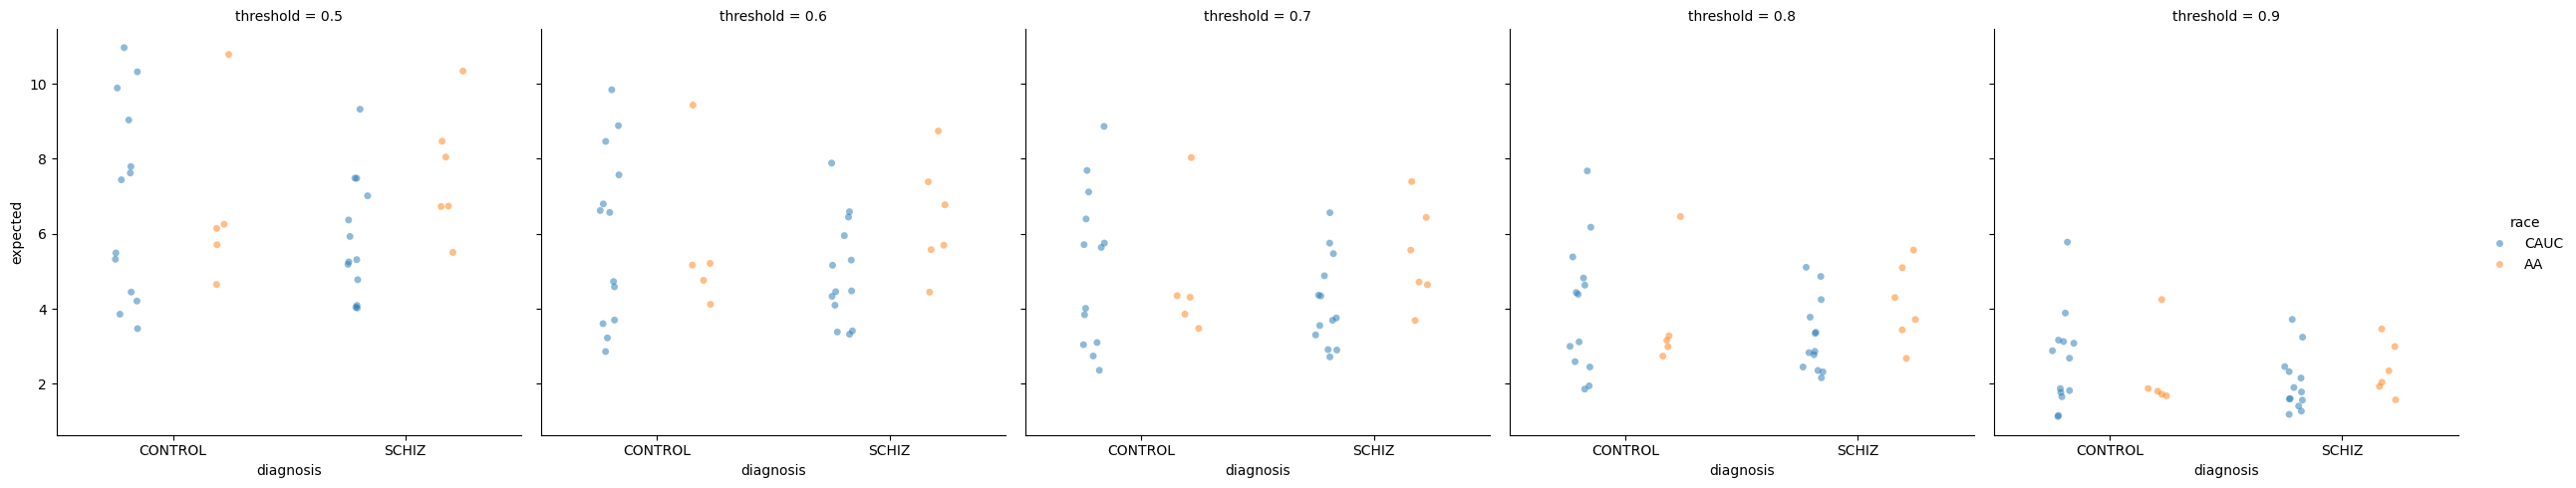

In [11]:
sns.catplot(
    data=donor_calls,
    x="diagnosis",
    y="expected",
    hue="race",
    col="threshold",
    kind="strip",
    alpha=0.5,
    jitter=0.1,
    dodge=True,
)

In [12]:
for t, df in donor_calls.groupby("threshold"):
    res = ttest_ind(
        df[df["diagnosis"] == "CONTROL"]["n_calls"],
        df[df["diagnosis"] == "SCZD"]["n_calls"],
    )
    print(f"ncalls diagnosis test at threshold {t}: {res}")
    res = ttest_ind(
        df[df["diagnosis"] == "CONTROL"]["expected"],
        df[df["diagnosis"] == "SCZD"]["expected"],
    )
    print(f"expected calls diagnosis test at threshold {t}: {res}")
    res = ttest_ind(
        df[df["race"] == "CAUC"]["n_calls"], df[df["race"] == "AA"]["n_calls"]
    )
    print(f"ncalls race test at threshold {t}: {res}")
    res = ttest_ind(
        df[df["race"] == "CAUC"]["expected"], df[df["race"] == "AA"]["expected"]
    )
    print(f"expected calls race test at threshold {t}: {res}")

ncalls diagnosis test at threshold 0.5: TtestResult(statistic=nan, pvalue=nan, df=nan)
expected calls diagnosis test at threshold 0.5: TtestResult(statistic=nan, pvalue=nan, df=nan)
ncalls race test at threshold 0.5: TtestResult(statistic=-0.8744382024069326, pvalue=0.38784067978854664, df=35.0)
expected calls race test at threshold 0.5: TtestResult(statistic=-1.0761835664475867, pvalue=0.28920772518979054, df=35.0)
ncalls diagnosis test at threshold 0.6: TtestResult(statistic=nan, pvalue=nan, df=nan)
expected calls diagnosis test at threshold 0.6: TtestResult(statistic=nan, pvalue=nan, df=nan)
ncalls race test at threshold 0.6: TtestResult(statistic=-0.7764356384440182, pvalue=0.4427075688134906, df=35.0)
expected calls race test at threshold 0.6: TtestResult(statistic=-0.9494152851629013, pvalue=0.34891952223419553, df=35.0)
ncalls diagnosis test at threshold 0.7: TtestResult(statistic=nan, pvalue=nan, df=nan)
expected calls diagnosis test at threshold 0.7: TtestResult(statistic=nan,

## Save

In [13]:
import pyranges as pr
from pathlib import Path

for d, df in data.query("test_proba > 0.5").groupby("donor_id"):
    my_df = df.rename(columns={"test_proba": "Score", "cell_id": "Name"})
    for s in snakemake.output:
        if d == Path(s).name.split(".")[0]:
            pr.PyRanges(my_df[["Chromosome", "Start", "End", "Score", "Name"]]).to_bed(
                s
            )
            break